**Project Statement:**

By Meetra Nouri

Goal:

We have been given the monthly production quantity for a certain agricultural product (let’s call it Grople syrup, note - no relation to actual Maple Syrup) in 10 different provinces of a country between January 2015 to December 2020. This Grople syrup comes from a fruit. It takes a few months for the fruits to grow on the trees which bear them. It also takes a few days to extract the syrup from the fruits after they have been harvested.

 

We would like to predict the production quantity for Grople syrup from Jan 2021 to Dec 2021.

 

Data:

**Production Quantity.csv** has 4 columns 
start_date, end_date: start day and end day of each month between January 2015 to Dec 2020.

prod: production quantity of Grople syrup in tonnes at monthly frequency
region_id: A unique identifier for the 10 provinces

Daily Precipitation.csv: has 4 columns 
start_date, end_date: start day and end day at a daily frequency between January 1, 2014 to Mar 13, 2022.
precip: Precipitation quantity (in mm) at daily frequency

region_id: A unique identifier for the 10 provinces

**Daily Soil Moisture.csv:** has 4 columns
start_date, end_date: start day and end day at daily frequency between January 1, 2014 to Mar 6, 2022.

smos: Soil Moisture at 5cm depth (measured by the ratio Vol/Vol) at daily frequency
region_id: A unique identifier for the 10 provinces

**Daily Temperature.csv:** has 4 columns
start_date, end_date: start day and end day at daily frequency between January 1, 2014 to Mar 13, 2022.

temp: Average daily temperature on the surface of the land (in celsius) at daily frequency

region_id: A unique identifier for the 10 provinces

**Eight Day NDVI.csv:** has 4 columns
start_date, end_date: start day and end day at 8-day frequency between Dec 27, 2013 to Mar 13, 2022.

ndvi: Normalized Difference Vegetation Index (NDVI is a ratio which ranges between [-1, 1] and captures the vegetation abundance of an area) at 8 day frequency between the given periods**

region_id: A unique identifier for the 10 provinces

**predicted_production_qty.csv:** has 4 columns 

start_date, end_date: start day and end day of each month between Jan 2021 to Dec 2021.

prod: This column needs to be filled by the candidate with their predictions of Grople syrup.

region_id: A unique identifier for the 10 provinces
 

In [ ]:
!pip install keras-tuner --upgrade

     |████████████████████████████████| 133 kB 6.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM

from keras.layers import Dense, Dropout, Activation
from keras import regularizers
#from keras.preprocessing.sequence import TimeseriesGenerator

from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


**Data Prepration**

In [ ]:
df_product=pd.read_csv("Production Quantity.csv", parse_dates=[0,1])
df_prec=pd.read_csv("Daily Precipitation.csv", parse_dates=[0,1])
df_soil=pd.read_csv("Daily Soil Mositure.csv", parse_dates=[0,1])
df_temp=pd.read_csv("Daily Temperature.csv", parse_dates=[0,1])
df_ndvi=pd.read_csv("Eight Day NDVI.csv", parse_dates=[0,1])

#test dataset
df_qty=pd.read_csv("predicted_production_qty.csv", parse_dates=[0,1])

In [ ]:
print(df_product.info())
print(df_prec.info())
print(df_soil.info()) 
print(df_temp.info())  
print(df_ndvi.info())  
print(df_qty.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   start_date  720 non-null    datetime64[ns, UTC]
 1   end_date    720 non-null    datetime64[ns, UTC]
 2   prod        720 non-null    int64              
 3   region_id   720 non-null    int64              
dtypes: datetime64[ns, UTC](2), int64(2)
memory usage: 22.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29940 entries, 0 to 29939
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   start_date  29940 non-null  datetime64[ns, UTC]
 1   end_date    29940 non-null  datetime64[ns, UTC]
 2   precip      29940 non-null  float64            
 3   region_id   29940 non-null  int64              
dtypes: datetime64[ns, UTC](2), float64(1), int64(1)
memory usage: 935.8 KB
None
<cl

In [ ]:
#checking for duplicates in dataset;
print(df_product.duplicated(subset=['start_date','region_id']).sum())
print(df_prec.duplicated(subset=['start_date','region_id']).sum())
print(df_soil.duplicated(subset=['start_date','region_id']).sum())
print(df_temp.duplicated(subset=['start_date','region_id']).sum())
print(df_ndvi.duplicated(subset=['start_date','region_id']).sum())


0
0
0
0
0


In [ ]:
#for simplicity let's drop "end_date" feature;
df_product= df_product.drop('end_date',axis=1).copy()
df_prec= df_prec.drop('end_date',axis=1).copy()
df_soil= df_soil.drop('end_date',axis=1).copy()
df_temp= df_temp.drop('end_date',axis=1).copy()
df_ndvi= df_ndvi.drop('end_date',axis=1).copy()

In [ ]:
#let's look at the datasets;
print(df_product.head(1))  
print(df_prec.head(1))
print(df_soil.head(1)) 
print(df_temp.head(1))  
print(df_ndvi.head(1))  

print(df_product.tail(1))
print(df_prec.tail(1))
print(df_soil.tail(1)) 
print(df_temp.tail(1))  
print(df_ndvi.tail(1))  

                 start_date    prod  region_id
0 2015-01-01 00:00:00+00:00  171725         93
                 start_date    precip  region_id
0 2014-01-01 00:00:00+00:00  1.392393         93
                 start_date      smos  region_id
0 2014-01-01 00:00:00+00:00  0.310787         93
                 start_date       temp  region_id
0 2014-01-02 00:00:00+00:00  24.707605         93
                 start_date      ndvi  region_id
0 2013-12-27 00:00:00+00:00  0.679106         93
                   start_date   prod  region_id
719 2020-12-01 00:00:00+00:00  35728        105
                     start_date    precip  region_id
29939 2022-03-13 00:00:00+00:00  2.719724        105
                     start_date      smos  region_id
29602 2022-03-06 00:00:00+00:00  0.442624        105
                     start_date       temp  region_id
12929 2022-03-13 00:00:00+00:00  26.088818        105
                    start_date      ndvi  region_id
3337 2022-03-06 00:00:00+00:00  0.795875    

In [ ]:
# let's create our training data by merging datasets;

df1=pd.merge(df_product,df_prec, on=['start_date','region_id'], how='left')

df2=pd.merge(df1,df_soil, on=['start_date','region_id'], how='left')

df3=pd.merge(df2,df_temp, on=['start_date','region_id'], how='left')

df_merged1=pd.merge(df3,df_ndvi, on=['start_date','region_id'], how='left')
print(df_merged1.info())
print(df_merged1.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   start_date  720 non-null    datetime64[ns, UTC]
 1   prod        720 non-null    int64              
 2   region_id   720 non-null    int64              
 3   precip      720 non-null    float64            
 4   smos        718 non-null    float64            
 5   temp        321 non-null    float64            
 6   ndvi        140 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 45.0 KB
None
                prod  region_id      precip        smos        temp  \
count     720.000000  720.00000  720.000000  718.000000  321.000000   
mean   159014.201389   99.00000    8.466546    0.269981   26.847293   
std    142882.722751    4.10163   11.675442    0.096114    2.539416   
min     10215.000000   93.00000    0.001005    0.050129

more than 80% of data is missing in "ndvi" column , so it's better to remove this column.

about 60% of data is missing in the "temp" column , let's fill this column using the mean which is 27.

there are few missing data in "smos" column , let's fill this column using "ffill"

In [ ]:
df_merged1.drop('ndvi',axis=1,inplace=True)

df_merged1['temp'].fillna(27, inplace=True)
df_merged1['smos'].fillna(0.27, inplace=True)

df_merged1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   start_date  720 non-null    datetime64[ns, UTC]
 1   prod        720 non-null    int64              
 2   region_id   720 non-null    int64              
 3   precip      720 non-null    float64            
 4   smos        720 non-null    float64            
 5   temp        720 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(2)
memory usage: 39.4 KB


In [ ]:
df_merged=df_merged1.groupby(by=['start_date','region_id']).mean()
df_merged[:13]

prod     precip      smos       temp
start_date                region_id                                          
2015-01-01 00:00:00+00:00 93         171725.0   2.278169  0.397555  27.000000
                          94          15066.0   0.029032  0.361954  23.491922
                          95          11181.0   0.149041  0.398271  19.884587
                          97          37505.0   0.079414  0.343651  27.000000
                          98         141442.0   0.063881  0.393050  27.000000
                          99         116186.0   0.239019  0.386206  21.209544
                          102        401299.0  19.875679  0.189944  24.372580
                          103        208233.0  12.107712  0.291713  27.000000
                          104         27384.0   0.441281  0.418575  27.000000
                          105         19382.0   0.460438  0.360012  27.000000
2015-02-01 00:00:00+00:00 93         188325.0   0.122923  0.392219  27.182920
                          94          20527.0   0.010335  0.324014  30.239199
                          95          11847.0   0.068482  0.368160  26.127185

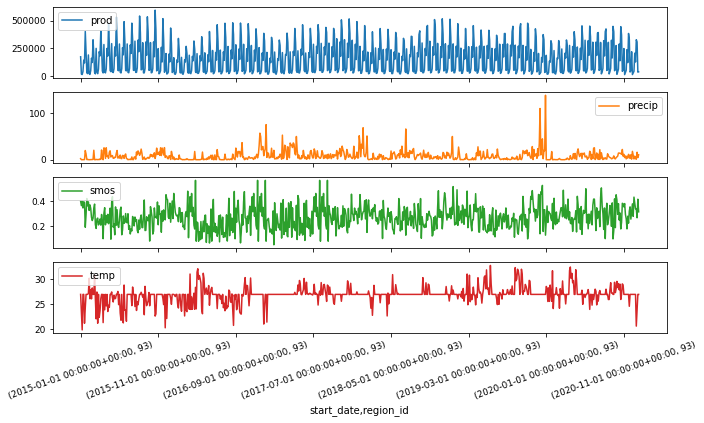

In [ ]:
df_merged.plot(subplots=True, figsize=(11,6), fontsize=9, rot=20);


In [ ]:
print(df_product.region_id.nunique())
print(df_prec.region_id.nunique())
print(df_soil.region_id.nunique())
print(df_temp.region_id.nunique())
print(df_ndvi.region_id.nunique())

10
10
10
10
10


In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df_train=scaler.fit_transform(df_merged[['prod',	'precip',	'smos',	'temp']])
df_train.shape

(720, 4)

In [ ]:
trainX=[]
trainY=[]

n_future=1 #number of timestamps we want to predict in future
n_past=20 #number of past timestamps we want to use to predict the future

for i in range(n_past, len(df_train)- n_future +1):
  trainX.append(df_train[i- n_past:i , 0:df_train.shape[1]])
  trainY.append(df_train[i+ n_future -1:i+ n_future, 0])

trainX, trainY=np.array(trainX), np.array(trainY)

In [ ]:
trainX.shape, trainY.shape

((700, 20, 4), (700, 1))

**LSTM Model**

Training the Data & Model Evaluation & Fine-Tune Model

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(units=hp.Int('units', min_value=32,max_value=256, step=32),
                 activation='relu', kernel_initializer='he_normal', input_shape=(n_past, 4), return_sequences=True))
  model.add(LSTM(units=hp.Int('units', min_value=16, max_value=128, step=16),
                 activation='relu', kernel_initializer='he_normal',return_sequences=True))
  model.add(Dropout(hp.Choice('rate', values=[0.2,0.3,0.4])))
  model.add(LSTM(units=hp.Int('units', min_value=16, max_value=64, step=16),
                 activation='relu', kernel_initializer='he_normal', return_sequences=False))
  model.add(Dropout(hp.Choice('rate', values=[0.2,0.3,0.4])))
  model.add(Dense(1))
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.0001,0.001,0.01,0.1]),clipnorm=1), loss='mse')
  return model

In [ ]:
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
 

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=6,
   directory='**checkpoint_filepath**',
)

In [ ]:
tuner.search(trainX, trainY, epochs=50,shuffle=False, batch_size=32, validation_split=0.25, callbacks=[model_checkpoint_callback, early_stopping])

Trial 6 Complete [00h 00m 57s]
val_loss: 0.004578823689371347

Best val_loss So Far: 0.004578823689371347
Total elapsed time: 00h 06m 57s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in **checkpoint_filepath**/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
rate: 0.4
learning_rate: 0.01
Score: 0.004578823689371347
Trial summary
Hyperparameters:
units: 128
rate: 0.2
learning_rate: 0.01
Score: 0.0048407865688204765
Trial summary
Hyperparameters:
units: 256
rate: 0.2
learning_rate: 0.0001
Score: 0.01840311661362648
Trial summary
Hyperparameters:
units: 192
rate: 0.2
learning_rate: 0.0001
Score: 0.02022196166217327
Trial summary
Hyperparameters:
units: 160
rate: 0.4
learning_rate: 0.0001
Score: 0.03192519024014473
Trial summary
Hyperparameters:
units: 128
rate: 0.4
learning_rate: 0.0001
Score: 0.056109145283699036


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.01.



In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 192)           151296    
                                                                 
 lstm_1 (LSTM)               (None, 20, 192)           295680    
                                                                 
 dropout (Dropout)           (None, 20, 192)           0         
                                                                 
 lstm_2 (LSTM)               (None, 192)               295680    
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense (Dense)               (None, 1)                 193       
                                                                 
Total params: 742,849
Trainable params: 742,849
Non-trai

In [ ]:
best_model.evaluate(trainX, trainY, verbose=0)

0.004439279902726412

In [ ]:
prediction=best_model.predict(trainX)

In [ ]:
prediction.shape

(700, 1)

In [ ]:
df_train[:,1:][n_past:].shape

(700, 3)

In [ ]:
df_pred=pd.concat([pd.DataFrame(prediction), pd.DataFrame(df_train[:,1:][n_past:])], axis=1)


In [ ]:
rev_trans=scaler.inverse_transform(df_pred)

In [ ]:
df_final=df_merged[prediction.shape[0]*-1:]
df_final.head()

prod    precip      smos       temp
start_date                region_id                                         
2015-03-01 00:00:00+00:00 93         247856.0  0.581672  0.180339  22.091759
                          94          31839.0  0.427642  0.255167  27.485688
                          95          18858.0  0.254019  0.262901  21.221056
                          97          59585.0  0.497751  0.208238  27.000000
                          98         218187.0  0.187027  0.220637  22.415666

In [ ]:
rev_trans.shape

(700, 4)

In [ ]:
df_final['prod_predict']=rev_trans[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_final

prod     precip      smos       temp  \
start_date                region_id                                             
2015-03-01 00:00:00+00:00 93         247856.0   0.581672  0.180339  22.091759   
                          94          31839.0   0.427642  0.255167  27.485688   
                          95          18858.0   0.254019  0.262901  21.221056   
                          97          59585.0   0.497751  0.208238  27.000000   
                          98         218187.0   0.187027  0.220637  22.415666   
...                                       ...        ...       ...        ...   
2020-12-01 00:00:00+00:00 99         124475.0   3.006772  0.336068  27.000000   
                          102        326135.0   0.952760  0.335132  20.639301   
                          103        306488.0  16.133662  0.265341  23.714268   
                          104         32747.0   4.609789  0.413316  27.000000   
                          105         35728.0  10.493345  0.312957  27.000000   

                                      prod_predict  
start_date                region_id                 
2015-03-01 00:00:00+00:00 93         172681.607792  
                          94          43821.064413  
                          95          42695.450997  
                          97          55749.130355  
                          98         154785.486284  
...                                            ...  
2020-12-01 00:00:00+00:00 99         141993.186413  
                          102        401717.268377  
                          103        328489.043221  
                          104         38899.900258  
                          105         44386.631085  

[700 rows x 5 columns]

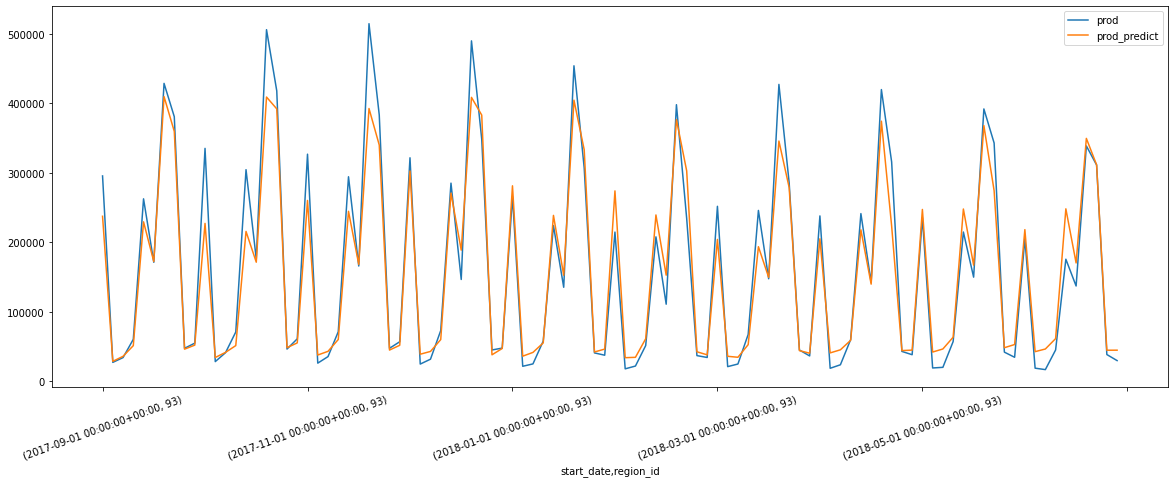

In [ ]:
df_final[['prod','prod_predict']][300:400].plot(figsize=(20,7), fontsize=10, rot=20);

**Forecasting**

In [ ]:
n_future=120
forcast=best_model.predict(trainX[-n_future:])

In [ ]:
forcast.shape

(120, 1)

In [ ]:
forcast_copies=np.repeat(forcast, df_merged.shape[1], axis=-1)

In [ ]:
forcast_copies[:2]

array([[0.3038169 , 0.3038169 , 0.3038169 , 0.3038169 ],
       [0.03460968, 0.03460968, 0.03460968, 0.03460968]], dtype=float32)

In [ ]:
y_pred_future=scaler.inverse_transform(forcast_copies)[:,0]

In [ ]:
y_pred_future[:3]

array([187450.84 ,  30405.04 ,  30821.975], dtype=float32)

In [ ]:
y_pred_future_series=pd.Series(y_pred_future)
y_pred_future_series

0      187450.843750
1       30405.039062
2       30821.974609
3       46943.156250
4      191321.296875
           ...      
115    141993.187500
116    401717.281250
117    328489.062500
118     38899.902344
119     44386.632812
Length: 120, dtype: float32

In [ ]:
df_qty['prod']=y_pred_future_series
df_qty.head()


,start_date,end_date,prod,region_id
0,2021-01-01 00:00:00+00:00,2021-01-31 00:00:00+00:00,187450.843750,93
1,2021-02-01 00:00:00+00:00,2021-02-28 00:00:00+00:00,30405.039062,93
2,2021-03-01 00:00:00+00:00,2021-03-31 00:00:00+00:00,30821.974609,93
3,2021-04-01 00:00:00+00:00,2021-04-30 00:00:00+00:00,46943.156250,93
4,2021-05-01 00:00:00+00:00,2021-05-31 00:00:00+00:00,191321.296875,93


In [ ]:
df_qty.to_csv('azamnouri2024@gmail.com.csv', index=True)

In [ ]:
df_qty1=df_qty.groupby(['start_date','region_id']).mean()
df_qty1

prod
start_date                region_id               
2021-01-01 00:00:00+00:00 93         187450.843750
                          94          40808.812500
                          95         147220.734375
                          97         300186.062500
                          98          41421.183594
...                                            ...
2021-12-01 00:00:00+00:00 99          36388.390625
                          102         55504.667969
                          103        172342.546875
                          104        377895.312500
                          105         44386.632812

[120 rows x 1 columns]

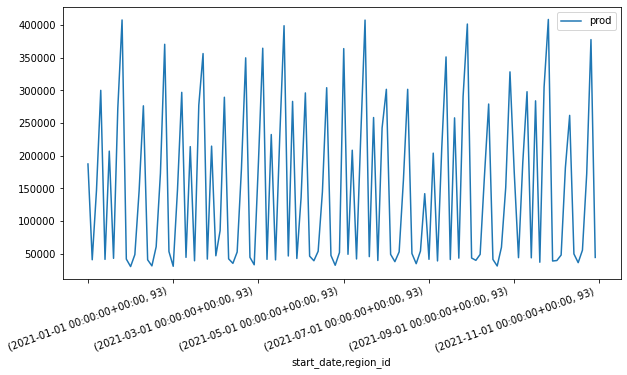

In [ ]:
df_qty1[['prod']].plot(figsize=(10,5), fontsize=10, rot=20);
